In [ ]:
import os
import cv2 as cv
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc



In [2]:
# Constants
TRAIN_DIR = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
TEST_DIR = "/kaggle/input/ucsd-anomaly-dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 10
MODEL_PATH = "model/model.hdf5"

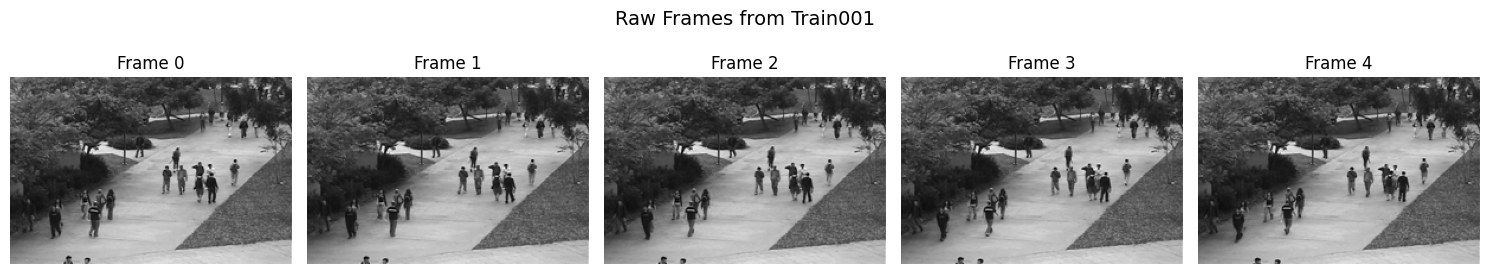

In [3]:
def visualize_frames(folder_dir, folder_name, num_frames=5):
    folder_path = os.path.join(folder_dir, folder_name)
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

    plt.figure(figsize=(15, 3))
    for i in range(num_frames):
        image_path = os.path.join(folder_path, tif_files[i])
        img = cv.imread(image_path, 0)
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Frame {i}")
        plt.axis('off')

    plt.suptitle(f"Raw Frames from {folder_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_frames(TRAIN_DIR, folder_name="Train001", num_frames=5)

### Load and Preprocess

In [4]:
def preprocess_clips(filepath, img_size, frames_per_clip=10, filter_with_gt=False):
    clips = []
    for folder in sorted(os.listdir(filepath)):
        folder_path = os.path.join(filepath, folder)
        if not os.path.isdir(folder_path):
            continue
        if filter_with_gt and not os.path.exists(os.path.join(filepath, folder + "_gt")):
            continue

        frames = []
        for file in sorted(os.listdir(folder_path)):
            if file.endswith('.tif'):
                img = cv.imread(os.path.join(folder_path, file), 0)
                img = cv.resize(img, (img_size, img_size)) / 255.0
                frames.append(img)

        for start in range(0, len(frames) - frames_per_clip + 1, frames_per_clip):
            clip = np.zeros((frames_per_clip, img_size, img_size, 1))
            for k in range(frames_per_clip):
                clip[k, :, :, 0] = frames[start + k]
            clips.append(clip)
        del frames
        gc.collect()

    return np.array(clips)

### Model

In [ ]:
def build_model():
    model = Sequential()
    # Encoder
    model.add(TimeDistributed(Conv2D(128, (5, 5), strides=4, padding='same'), input_shape=(10, IMG_SIZE, IMG_SIZE, 1)))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(64, (3, 3), strides=2, padding='same')))
    model.add(LayerNormalization())

    # Bottleneck
    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())

    # Decoder
    model.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same')))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2DTranspose(128, (6, 6), strides=4, padding='same')))
    model.add(LayerNormalization())
    model.add(TimeDistributed(Conv2D(1, (5, 5), activation="sigmoid", padding='same')))
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    return model

### Predict

In [6]:
def predict_in_batches(model, data, batch_size=8):
    preds = []
    for i in range(0, len(data), batch_size):
        preds.append(model.predict(data[i:i+batch_size], verbose=0))
    return np.concatenate(preds, axis=0)

### Ground Truth Labels

In [7]:
def generate_frame_labels(gt_base_dir):
    labels = []
    for folder in sorted(os.listdir(gt_base_dir)):
        if not folder.endswith("_gt"):
            continue
        folder_path = os.path.join(gt_base_dir, folder)
        for bmp in sorted([f for f in os.listdir(folder_path) if f.endswith('.bmp')]):
            mask = cv.imread(os.path.join(folder_path, bmp), 0)
            labels.append(1 if np.any(mask > 0) else 0)
    return np.array(labels)

### ROC-AUC 

In [8]:
def evaluate_model(model, test_data, true_labels):
    reconstructed = predict_in_batches(model, test_data)
    frame_errors = np.mean((test_data - reconstructed) ** 2, axis=(2, 3, 4)).flatten()
    fpr, tpr, _ = roc_curve(true_labels, frame_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"AUC Score: {roc_auc}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1751729929.040341      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751729929.041084      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1751729951.593016     103 service.cc:148] XLA service 0x37f2f2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751729951.593703     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751729951.593731     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751729953.035030     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751729969.441132     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 88s 665ms/step - loss: 0.0433
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 710ms/step - loss: 0.0087
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 706ms/step - loss: 0.0069
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 708ms/step - loss: 0.0057
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 709ms/step - loss: 0.0048
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 708ms/step - loss: 0.0044
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 708ms/step - loss: 0.0039
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 708ms/step - loss: 0.0037
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 709ms/step - loss: 0.0034
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 708ms/step - loss: 0.0032


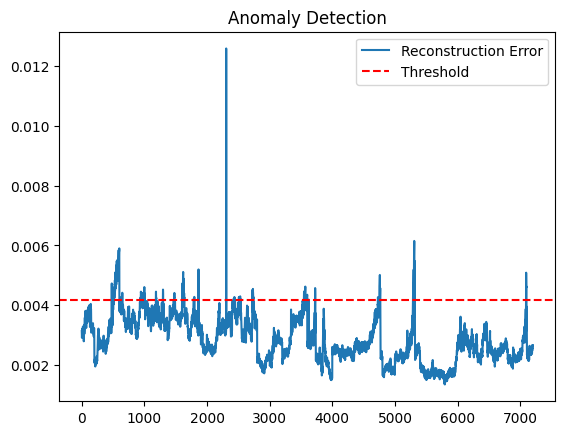

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


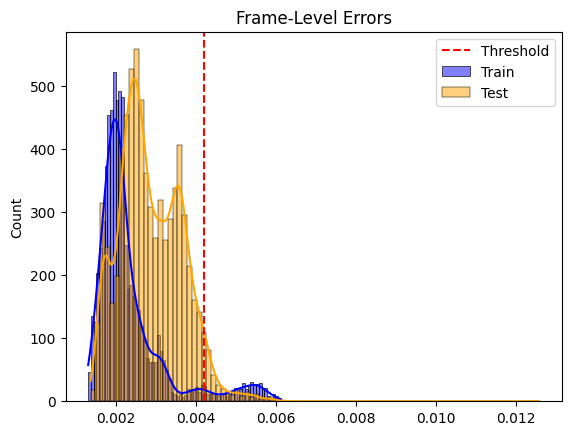

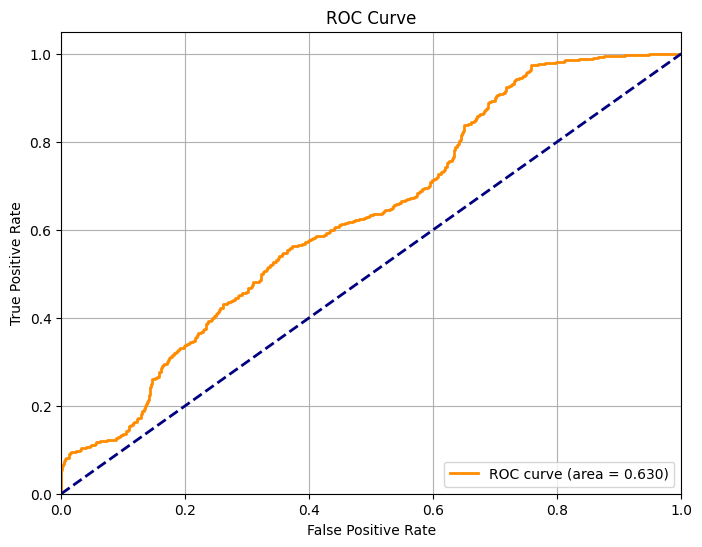

AUC Score: 0.6302103675478289


In [ ]:
if __name__ == "__main__":
    MODEL_PATH = "model/model.hdf5" 

    training_data = preprocess_clips(TRAIN_DIR, IMG_SIZE)

    if os.path.exists(MODEL_PATH):
        print(f"Model found at {MODEL_PATH}. Loading pre-trained model.")
        model = load_model(MODEL_PATH, compile=False)
    else:
        print(f"Model not found at {MODEL_PATH}. Starting training...")
        # If model doesn't exist, run the training process
        training_data = preprocess_clips(TRAIN_DIR, IMG_SIZE)
        model = build_model()
        model.fit(training_data, training_data, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"Training complete. Saving model to {MODEL_PATH}")
        model.save(MODEL_PATH)

    train_reconstructed = predict_in_batches(model, training_data)
    train_errors = np.mean((training_data - train_reconstructed)**2, axis=(2, 3, 4)).flatten()
    threshold = np.mean(train_errors) + 2 * np.std(train_errors)

    test_data_all = preprocess_clips(TEST_DIR, IMG_SIZE)
    test_reconstructed_all = predict_in_batches(model, test_data_all)
    test_errors_all = np.mean((test_data_all - test_reconstructed_all)**2, axis=(2,3,4)).flatten()

    plt.plot(test_errors_all, label="Reconstruction Error")
    plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.title("Anomaly Detection")
    plt.show()

    sns.histplot(train_errors, color='blue', label='Train', kde=True)
    sns.histplot(test_errors_all, color='orange', label='Test', kde=True)
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.title("Frame-Level Errors")
    plt.show()

    test_data_gt = preprocess_clips(TEST_DIR, IMG_SIZE, filter_with_gt=True)
    labels = generate_frame_labels(TEST_DIR)
    evaluate_model(model, test_data_gt, labels)